In [41]:
import pandas as pd
import numpy as np

In [42]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

--2025-10-20 20:35:19--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv.2’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.07s   

2025-10-20 20:35:20 (1.06 MB/s) - ‘course_lead_scoring.csv.2’ saved [80876/80876]



In [43]:
df = pd.read_csv("course_lead_scoring.csv")

In [44]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [45]:
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=['number']).columns

In [46]:
df[categorical_cols] = df[categorical_cols].fillna('NA')
df[numerical_cols] = df[numerical_cols].fillna(0.0)

In [47]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NA,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NA,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [48]:
from sklearn.model_selection import train_test_split

In [49]:
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=1)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=1)

X_train = train_df.drop(columns=['converted'])
X_val = val_df.drop(columns=['converted'])
X_test = test_df.drop(columns=['converted'])

In [50]:
print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

Train: (877, 8), Validation: (292, 8), Test: (293, 8)


In [51]:
from sklearn.metrics import roc_auc_score

# Define the target variable for the training set
y_train = train_df['converted']

# Select the four numerical variables specified in the question
num_features = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']

# Compute ROC AUC for each numerical variable
auc_scores = {}

for col in num_features:
    auc = roc_auc_score(y_train, train_df[col])
    
    # If AUC < 0.5, invert the variable
    if auc < 0.5:
        auc = roc_auc_score(y_train, -train_df[col])
    
    auc_scores[col] = auc

# Display AUC values for each feature
for feature, auc in auc_scores.items():
    print(f"{feature}: {auc:.3f}")

# Identify the variable with the highest AUC
best_feature = max(auc_scores, key=auc_scores.get)
print(f"\nThe numerical variable with the highest AUC is: {best_feature}")


lead_score: 0.611
number_of_courses_viewed: 0.765
interaction_count: 0.727
annual_income: 0.545

The numerical variable with the highest AUC is: number_of_courses_viewed


In [52]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Define the target and features
y_train = train_df['converted']
y_val = val_df['converted']

X_train = train_df.drop(columns=['converted'])
X_val = val_df.drop(columns=['converted'])

# Convert dataframes to dictionaries for DictVectorizer
train_dicts = X_train.to_dict(orient='records')
val_dicts = X_val.to_dict(orient='records')

# Initialize DictVectorizer for one-hot encoding
dv = DictVectorizer(sparse=False)
X_train_encoded = dv.fit_transform(train_dicts)
X_val_encoded = dv.transform(val_dicts)

# Train the logistic regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_encoded, y_train)

# Predict probabilities on the validation set
y_val_pred = model.predict_proba(X_val_encoded)[:, 1]

# Compute ROC AUC
auc = roc_auc_score(y_val, y_val_pred)
print(f"Validation AUC: {auc:.3f}")

Validation AUC: 0.794


/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


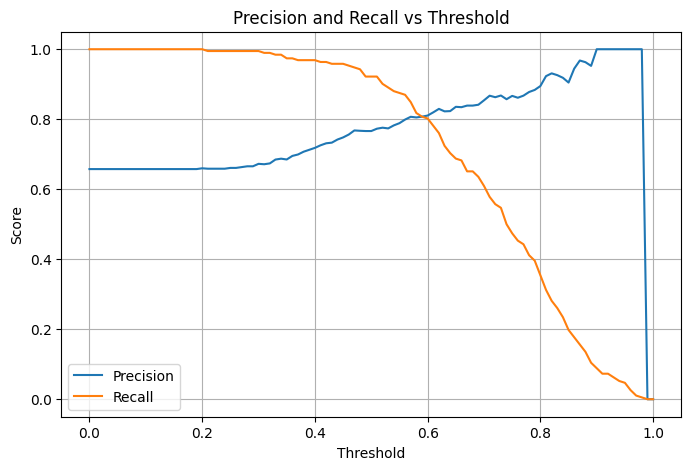

Threshold where precision and recall intersect: 0.590


In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

# y_val: true labels
# y_val_pred: predicted probabilities from your model

thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []

for t in thresholds:
    preds = (y_val_pred >= t).astype(int)
    precisions.append(precision_score(y_val, preds))
    recalls.append(recall_score(y_val, preds))

# Convert to numpy arrays for easier computation
precisions = np.array(precisions)
recalls = np.array(recalls)

# Plot precision and recall
plt.figure(figsize=(8,5))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Find threshold where precision and recall curves intersect
# (closest point where absolute difference is minimum)
idx = np.argmin(np.abs(precisions - recalls))
threshold_intersect = thresholds[idx]
print(f"Threshold where precision and recall intersect: {threshold_intersect:.3f}")


Threshold where F1 is maximal: 0.470


/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


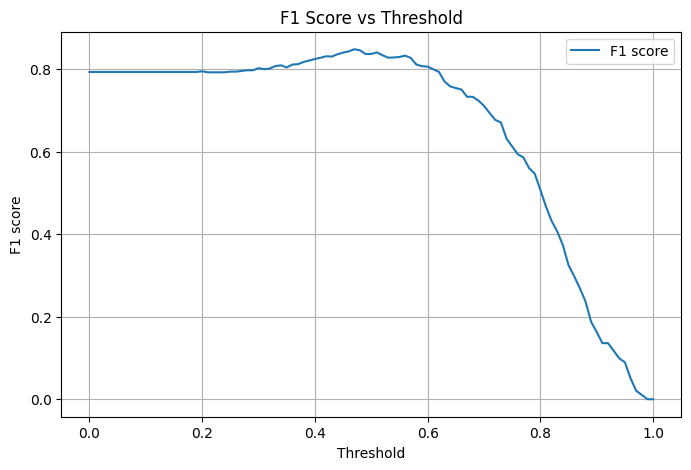

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

# Thresholds from 0.0 to 1.0
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

# Compute F1 score for each threshold
for t in thresholds:
    y_pred_thresh = (y_val_pred >= t).astype(int)
    P = precision_score(y_val, y_pred_thresh)
    R = recall_score(y_val, y_pred_thresh)
    F1 = 2 * P * R / (P + R) if (P + R) > 0 else 0  # avoid division by zero
    f1_scores.append(F1)

f1_scores = np.array(f1_scores)

# Find threshold where F1 is maximal
idx_max = np.argmax(f1_scores)
threshold_max_f1 = thresholds[idx_max]
print(f"Threshold where F1 is maximal: {threshold_max_f1:.3f}")

# Optional: plot F1 score vs threshold
plt.figure(figsize=(8,5))
plt.plot(thresholds, f1_scores, label='F1 score')
plt.xlabel('Threshold')
plt.ylabel('F1 score')
plt.title('F1 Score vs Threshold')
plt.grid(True)
plt.legend()
plt.show()


In [55]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Full dataset for CV
df_full_train = df.copy()
y_full = df_full_train['converted']
X_full = df_full_train.drop(columns=['converted'])

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=1)

auc_scores = []

# Iterate over folds
for train_idx, val_idx in kf.split(X_full):
    X_train_cv, X_val_cv = X_full.iloc[train_idx], X_full.iloc[val_idx]
    y_train_cv, y_val_cv = y_full.iloc[train_idx], y_full.iloc[val_idx]
    
    # DictVectorizer
    dv = DictVectorizer(sparse=False)
    X_train_encoded = dv.fit_transform(X_train_cv.to_dict(orient='records'))
    X_val_encoded = dv.transform(X_val_cv.to_dict(orient='records'))
    
    # Logistic Regression
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_encoded, y_train_cv)
    
    # Predict probabilities and compute AUC
    y_val_pred = model.predict_proba(X_val_encoded)[:, 1]
    auc = roc_auc_score(y_val_cv, y_val_pred)
    auc_scores.append(auc)

# Compute standard deviation of AUC scores across folds
auc_std = np.std(auc_scores)
print("AUC scores for each fold:", [round(s, 3) for s in auc_scores])
print(f"Standard deviation of AUC across folds: {auc_std:.3f}")


AUC scores for each fold: [0.817, 0.779, 0.831, 0.868, 0.809]
Standard deviation of AUC across folds: 0.029


In [56]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# C values to test
C_values = [0.000001, 0.001, 1]

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Store results
results = []

for C in C_values:
    auc_scores = []
    
    for train_idx, val_idx in kf.split(X_full):
        X_train_cv, X_val_cv = X_full.iloc[train_idx], X_full.iloc[val_idx]
        y_train_cv, y_val_cv = y_full.iloc[train_idx], y_full.iloc[val_idx]
        
        # DictVectorizer
        dv = DictVectorizer(sparse=False)
        X_train_encoded = dv.fit_transform(X_train_cv.to_dict(orient='records'))
        X_val_encoded = dv.transform(X_val_cv.to_dict(orient='records'))
        
        # Train logistic regression
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_encoded, y_train_cv)
        
        # Predict and compute AUC
        y_val_pred = model.predict_proba(X_val_encoded)[:, 1]
        auc = roc_auc_score(y_val_cv, y_val_pred)
        auc_scores.append(auc)
    
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)
    results.append((C, round(mean_auc, 3), round(std_auc, 3)))

# Print results
print("C\tMean AUC\tStd AUC")
for r in results:
    print(f"{r[0]}\t{r[1]}\t\t{r[2]}")

# Determine best C
# Best mean -> lowest std if tie -> smallest C if tie
results_sorted = sorted(results, key=lambda x: (-x[1], x[2], x[0]))
best_C = results_sorted[0][0]
print(f"\nBest C: {best_C}")


C	Mean AUC	Std AUC
1e-06	0.549		0.03
0.001	0.862		0.024
1	0.821		0.029

Best C: 0.001
